In [2]:
#Imports and API Key
#building in offsets

#checkout scikit learn timeseries 
#checkout cross validation - rolling window

#Imports and API Key

import pandas as pd
import quandl
from scipy import stats
import scipy
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

from sklearn.pipeline import Pipeline

from basis_expansions.basis_expansions import (
    Polynomial, LinearSpline)

from regression_tools.dftransformers import (
    ColumnSelector, Identity, FeatureUnion, MapFeature, Intercept)

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeClassifier

import sys
import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit

import xgboost as xgb
from xgboost import plot_importance

%aimport dataclean

quandl.ApiConfig.api_key = 'm8FYMyoCaJSbTrBASNHh'

from xgboost import plot_importance

In [3]:
#pulling data from Quandl

data = pd.read_csv('datasources2.csv') #staging the QUANDL keys to pull in CSV
cols = list(data['Var_name'].astype('str'))
dataset = quandl.get([val for val in data['Quandl Key']]) #looping through the QUANDL keys to pull it into one DF
dataset.columns = cols

In [4]:
#pulling FED Yield Curve data

yields = pd.read_csv('Fed10Y_3M.csv')
yields['Date'] = pd.to_datetime(yields['Date'])
mask = (yields['Date'] > pd.datetime(2058,1,1))
yields.loc[mask,'Date'] = yields.loc[mask,'Date'].apply(lambda x: x - pd.DateOffset(years=100))

yields['Date'] = yields['Date'].apply(lambda x: x.strftime('%Y-%m'))

yields = yields.set_index('Date')
yields = yields.drop(['3 Month Treasury Yield', 'Rec_prob', 'NBER_Rec'], axis=1) 

In [5]:
#need to write in special logic to factor in for 3YRT being a daily

treas = dataset['3YRT']
dataset = dataset.drop(columns = ['3YRT'])

In [6]:
treas = treas.resample('MS').mean()

In [7]:
## back to working on the general data
dataset.index = dataset.index.strftime('%Y-%m') #converting the datetime index to Y/M so it is collapsable
dataset = dataset.groupby(dataset.index, as_index=True).agg(sum) #collapsing by Y/M

In [8]:
#readd 3YRT back into data

dataset = dataset.join(treas, how='outer')

In [9]:
#converting GDP quarterly data into monthly - need to convert it so it fills in the following 3 months

dataset = dataclean.convert_q_to_m(dataset, 'GDP')

#converting consumer sentiment into monthly

dataset = dataclean.convert_q_to_m(dataset, 'CONS_SENT')

In [10]:
offset_dict = {'PMI':1, 'UNR':1, 'YUNR':1,'US_NHOME_SALES':1, 'PART_TIME':1, 'CPPR_PRICE':1, 'HOUS_PERMS':1, 'HOUS_STARTS':1, 'CAP_UTIL':1, 'PERS_SAVINGS':3, 'EXPORTS':3, 'IMPORTS':3, 'TRADE_BALANCE':3, 'US_M2':1, 'US_NHOME_SALES':1,'PPI':1,'CPI':1} #positives shift down, negatives shift up. Goal of this dict is to align data to when it gets released

In [11]:
for entry in offset_dict:
    #print(entry)
    #print(offset_dict[entry])
    dataset[str(entry)] = dataset[str(entry)].shift(offset_dict[entry])

In [12]:
#calculating change in GDP and converting Y into categorical values 
dataset['Recession'] = ((dataset['GDP'] - dataset['GDP'].shift(3)) < 0).astype(int)
dataset = dataset.drop(columns = ['GDP']) #dropping calc column and recession column from dataset, experimenting with taking out fed funds rate

In [13]:
#merge fed interest rate data here
dataset = dataset.join(yields, how='outer')

In [14]:
dataset = dataset[552:]

In [15]:
dataset = dataset[:-11]

In [16]:
#substituting mean value in for missing values and adding dummy column to indicate where done.

#this could be leakage, use backwards looking means

for col in dataset.columns:
    if str(col)=='Recession':
        continue
    dataclean.clean_zeros(col, dataset)

In [17]:
dataset['3YRT'] = dataset['3YRT'].fillna(dataset['3YRT'].mean())

In [18]:
#adding momentum factors

momentum_cols = list(dataset.columns[:-6])

momentum_cols.remove('PPI') #removing PPI and CPI because they need a different transformation
momentum_cols.remove('CPI')
momentum_cols.remove('Recession')

for i in [1,3,12]:
    for col in momentum_cols:
        if 'PXY' in str(col): #adding logic so it doesn't create a momentum column out of PXY columns
            continue
        dataclean.create_momentum(col,dataset,i)

In [19]:
#CPI Calcs

for i in [1,3,12]:
    for col in ['CPI','PPI']:
        dataclean.infl_momentum(col,dataset,i)

In [20]:
#cutoff most of missing data, Post March 2019, Prior 1959. CPI/PPI missing 2016 onward so need to cut that off
#dataset = dataset.iloc[552:]
#dataset = dataset.iloc[:-2]

#y = y.iloc[552:]
y = dataset['Recession']
dataset = dataset.drop(columns = ['Recession'])
X = dataset

In [21]:
### Data Prep Finished Here ###

In [22]:
time = [0,-1,-3,-12]
result1 = pd.DataFrame(y.iloc[550:723].values)
result1.index = y.iloc[550:723].index

params = {0:[4,0.005,500],-1:[5,0.005,500],-3:[10,0.01,300],-12:[1,0.005,500]}

for point in time:
    
    model = xgb.XGBClassifier(learning_rate=params[point][1],
                                   n_estimators=params[point][2], #bump this and learning rate to make more trees, trees(not exact) = n*learning rate
                                   min_samples_leaf=4,
                                   max_depth=params[point][0],
                                   subsample=0.5)
    
    X = dataset
    
    y_shift = y.shift(point) #needs to be negative to look forward
    y_shift = y_shift.fillna(0)
    
    X_train = X.iloc[12:550]
    X_test = X.iloc[550:723]
    y_train = y_shift.iloc[12:550]
    y_test = y_shift.iloc[550:723]
    
    #model = LogisticRegression(penalty = 'l2', C=2000, max_iter = 100, solver = 'sag') #try throwing in a bigger C than 1
    #RidgeClassifier().fit(X, y)
    model.fit(X_train, y_train)
    
    probs = model.predict_proba(X_test)
    
    result1[str(point)] = probs[:,1]
    
    #print(probs[:,1])
    

In [23]:
result1 = result1.drop(columns = 0)

In [24]:
result1.columns = ['Current Month','1 Month Horizon','3 Month Horizon','12 Month Horizon']

/anaconda3/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Date')

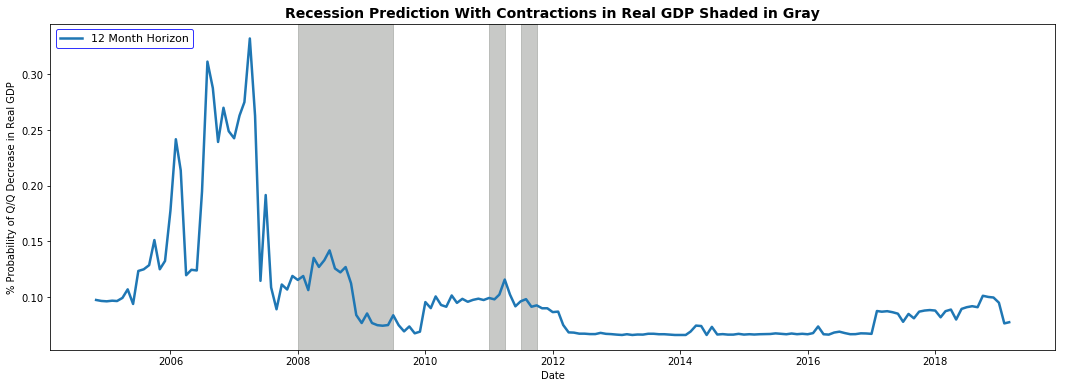

In [25]:
x = result1.index
a = result1.iloc[:,0]
b = result1.iloc[:,1]
c = result1.iloc[:,2]
d = result1.iloc[:,3]

fig, ax = plt.subplots(figsize=(18, 6))
#ax.plot(x, a, linewidth=2.5, zorder=2)
#ax.plot(x, b, linewidth=2.5, zorder=2)
#ax.plot(x, c, linewidth=2.5, zorder=2)
ax.plot(x, d, linewidth=2.5, zorder=2)
ax.scatter(x, d, s=0, zorder=1, label='_nolegend_')
ax.axvspan(x[38],x[56], color=sns.xkcd_rgb['grey'], alpha=0.5)
ax.axvspan(x[74],x[77], color=sns.xkcd_rgb['grey'], alpha=0.5)
ax.axvspan(x[80],x[83], color=sns.xkcd_rgb['grey'], alpha=0.5)

ax.set_title('Recession Prediction With Contractions in Real GDP Shaded in Gray', fontsize=14, fontweight='demi')

ax.legend(loc='upper left', fontsize=11, frameon=True).get_frame().set_edgecolor('blue')

ax.set_ylabel('% Probability of Q/Q Decrease in Real GDP')
ax.set_xlabel('Date')

In [26]:
result1.head()

,Current Month,1 Month Horizon,3 Month Horizon,12 Month Horizon
2004-11-01,0.048269,0.059076,0.067288,0.097290
2004-12-01,0.061321,0.074639,0.070041,0.096423
2005-01-01,0.053577,0.097497,0.084445,0.096082
2005-02-01,0.051860,0.073498,0.067991,0.096648
2005-03-01,0.062600,0.074146,0.082246,0.096342


In [77]:
X = dataset

In [78]:
y_shift = y.shift(-12) #needs to be negative to look forward
y_shift = y_shift.fillna(0)

In [79]:
X_train = X.iloc[12:550]
X_test = X.iloc[550:723]
y_train = y_shift.iloc[12:550]
y_test = y_shift.iloc[550:723]

In [80]:
model = xgb.XGBClassifier(learning_rate=0.001,
                                   n_estimators=1500, #bump this and learning rate to make more trees, trees(not exact) = n*learning rate
                                   min_samples_leaf=4,
                                   max_depth=1,
                                   subsample=0.5)

model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.001, max_delta_step=0,
       max_depth=1, min_child_weight=1, min_samples_leaf=4, missing=None,
       n_estimators=1500, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.5)

In [81]:
probs = model.predict_proba(X_test)

In [82]:
log_loss(y_test, probs)

0.39334529173167454

In [83]:
roc_auc_score(y_test.values, probs[:,1:])

0.7269295302013421

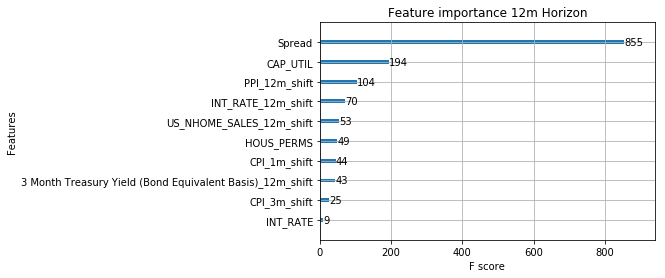

In [84]:
plot_importance(model, max_num_features = 10, title='Feature importance 12m Horizon')

In [76]:
probs

array([[0.9517306 , 0.0482694 ],
       [0.93867886, 0.06132117],
       [0.9464233 , 0.05357673],
       [0.94814026, 0.05185972],
       [0.9373999 , 0.06260009],
       [0.93269837, 0.0673016 ],
       [0.94038403, 0.05961597],
       [0.9403086 , 0.05969146],
       [0.94836915, 0.05163082],
       [0.9308758 , 0.06912424],
       [0.90150803, 0.09849194],
       [0.67044115, 0.32955888],
       [0.9100915 , 0.08990849],
       [0.9413132 , 0.0586868 ],
       [0.9470229 , 0.0529771 ],
       [0.9449107 , 0.05508931],
       [0.94567055, 0.05432944],
       [0.9474229 , 0.0525771 ],
       [0.91994995, 0.08005006],
       [0.9462244 , 0.0537756 ],
       [0.9380252 , 0.06197483],
       [0.88108975, 0.11891028],
       [0.8461125 , 0.15388751],
       [0.87836385, 0.12163617],
       [0.8719909 , 0.12800908],
       [0.87767196, 0.12232807],
       [0.8959823 , 0.10401769],
       [0.775005  , 0.22499502],
       [0.8751216 , 0.12487844],
       [0.8828873 , 0.11711268],
       [0.

In [62]:
results = pd.DataFrame(probs)
results['actual'] = y_test.values
results.index = y_test.index
pd.set_option('display.float_format', lambda x: '%.3f' % x)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(results)

               0     1  actual
2004-11-01 0.678 0.322   0.000
2004-12-01 0.678 0.322   0.000
2005-01-01 0.678 0.322   0.000
2005-02-01 0.678 0.322   0.000
2005-03-01 0.678 0.322   0.000
2005-04-01 0.678 0.322   0.000
2005-05-01 0.678 0.322   0.000
2005-06-01 0.678 0.322   0.000
2005-07-01 0.678 0.322   0.000
2005-08-01 0.678 0.322   0.000
2005-09-01 0.676 0.324   0.000
2005-10-01 0.582 0.418   0.000
2005-11-01 0.678 0.322   0.000
2005-12-01 0.678 0.322   0.000
2006-01-01 0.678 0.322   0.000
2006-02-01 0.678 0.322   0.000
2006-03-01 0.678 0.322   0.000
2006-04-01 0.678 0.322   0.000
2006-05-01 0.678 0.322   0.000
2006-06-01 0.678 0.322   0.000
2006-07-01 0.672 0.328   0.000
2006-08-01 0.594 0.406   0.000
2006-09-01 0.592 0.408   0.000
2006-10-01 0.592 0.408   0.000
2006-11-01 0.592 0.408   0.000
2006-12-01 0.592 0.408   0.000
2007-01-01 0.592 0.408   0.000
2007-02-01 0.592 0.408   0.000
2007-03-01 0.592 0.408   0.000
2007-04-01 0.592 0.408   0.000
2007-05-01 0.594 0.406   0.000
2007-06-

In [67]:
#Grid Search

max_depth = [1,2,3,4,5,7,10]
n_est = [100, 200, 300,500, 1000,1500,2000]
learning_rate = [0.001,0.005,0.010]

for depth in max_depth:
    for n in n_est:
        for r in learning_rate:

            model = xgb.XGBClassifier(learning_rate=r,
                                       n_estimators=n, #bump this and learning rate to make more trees, trees(not exact) = n*learning rate
                                       min_samples_leaf=4,
                                       max_depth=depth,
                                       subsample=0.5)
            model.fit(X_train, y_train) #fitting model
            probs = model.predict_proba(X_test)
            ll = log_loss(y_test, probs)
            auc = roc_auc_score(y_test.values, probs[:,1:])
            print("Testing max depth {}, learning rate {} and n_est of {}, yielding log loss of {} and AUC of {}".format(depth,r, n, ll, auc))

Testing max depth 1, learning rate 0.001 and n_est of 100, yielding log loss of 0.6327811934355366 and AUC of 0.8150167785234899
Testing max depth 1, learning rate 0.005 and n_est of 100, yielding log loss of 0.47209659511643337 and AUC of 0.8102628635346755
Testing max depth 1, learning rate 0.01 and n_est of 100, yielding log loss of 0.3693050452739517 and AUC of 0.8101230425055927
Testing max depth 1, learning rate 0.001 and n_est of 200, yielding log loss of 0.582551495532769 and AUC of 0.8087248322147651
Testing max depth 1, learning rate 0.005 and n_est of 200, yielding log loss of 0.3706780633313118 and AUC of 0.8517897091722596
Testing max depth 1, learning rate 0.01 and n_est of 200, yielding log loss of 0.2943647614965549 and AUC of 0.8506711409395974
Testing max depth 1, learning rate 0.001 and n_est of 300, yielding log loss of 0.5402752626148951 and AUC of 0.8084451901565995
Testing max depth 1, learning rate 0.005 and n_est of 300, yielding log loss of 0.32022716776828547

Testing max depth 4, learning rate 0.005 and n_est of 100, yielding log loss of 0.4679906840269276 and AUC of 0.8808724832214765
Testing max depth 4, learning rate 0.01 and n_est of 100, yielding log loss of 0.3609443624756929 and AUC of 0.8719239373601789
Testing max depth 4, learning rate 0.001 and n_est of 200, yielding log loss of 0.5801900639010302 and AUC of 0.8777964205816555
Testing max depth 4, learning rate 0.005 and n_est of 200, yielding log loss of 0.3616398391179267 and AUC of 0.8738814317673378
Testing max depth 4, learning rate 0.01 and n_est of 200, yielding log loss of 0.2810982568674005 and AUC of 0.8713646532438479
Testing max depth 4, learning rate 0.001 and n_est of 300, yielding log loss of 0.5362103519412135 and AUC of 0.8766778523489933
Testing max depth 4, learning rate 0.005 and n_est of 300, yielding log loss of 0.3071235909713486 and AUC of 0.8766778523489932
Testing max depth 4, learning rate 0.01 and n_est of 300, yielding log loss of 0.26913350103476835 

Testing max depth 10, learning rate 0.01 and n_est of 100, yielding log loss of 0.3622873606364851 and AUC of 0.8709451901565997
Testing max depth 10, learning rate 0.001 and n_est of 200, yielding log loss of 0.5817402646031683 and AUC of 0.8800335570469799
Testing max depth 10, learning rate 0.005 and n_est of 200, yielding log loss of 0.36243084736297587 and AUC of 0.8716442953020135
Testing max depth 10, learning rate 0.01 and n_est of 200, yielding log loss of 0.281429003127393 and AUC of 0.8696868008948545
Testing max depth 10, learning rate 0.001 and n_est of 300, yielding log loss of 0.5385971563744407 and AUC of 0.8800335570469798
Testing max depth 10, learning rate 0.005 and n_est of 300, yielding log loss of 0.3075907363454041 and AUC of 0.8752796420581654
Testing max depth 10, learning rate 0.01 and n_est of 300, yielding log loss of 0.26709641447301546 and AUC of 0.8671700223713646
Testing max depth 10, learning rate 0.001 and n_est of 500, yielding log loss of 0.468417758

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(y)

In [ ]:
print(sum(y))

In [ ]:
X_train

In [ ]:
model.feature_importances_

In [ ]:
plot_importance(model, max_num_features = 10, title = 'Feature Importance for Predicting Contractions in Real GDP 12 Months Out')

In [ ]:
for combo in zip(X_train.columns,model.feature_importances_):
    print(combo)

In [ ]:
importance = pd.DataFrame(zip(X_train.columns,model.feature_importances_), columns = ['Indicator','Importance'])

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(importance.sort_values(['Importance'], ascending = False))

In [ ]:
X_train.head(100)

In [ ]:
X = X.iloc[12:]
y = y.iloc[12:]

In [ ]:
tscv = TimeSeriesSplit(n_splits=4)

In [ ]:
TimeSeriesSplit(max_train_size=None, n_splits=4)

In [ ]:
for train_index, test_index in tscv.split(X):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    #print(X_train, y_train)
    
    
    model = xgb.XGBClassifier(learning_rate=0.005,
                                   n_estimators=1000, #bump this and learning rate to make more trees, trees(not exact) = n*learning rate
                                   min_samples_leaf=4,
                                   max_depth=1,
                                   subsample=0.5)

    model.fit(X_train, y_train)
    
    probs = model.predict_proba(X_test)
    
    #print(probs)
    
    print(log_loss(y_test, probs))
    
    print(roc_auc_score(y_test.values, probs[:,1:]))
    
    results = pd.DataFrame(probs)
    results['actual'] = y_test.values
    results.index = y_test.index
    pd.set_option('display.float_format', lambda x: '%.3f' % x)
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        print(results)
    

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(y)

In [ ]:
#Grid Search

max_depth = [1,2,3,4,5,7,10]
n_est = [100, 200, 300,500, 1000,1500,2000]
learning_rate = [0.001,0.005,0.010]

for depth in max_depth:
    for n in n_est:
        for r in learning_rate:

            model = xgb.XGBClassifier(learning_rate=r,
                                       n_estimators=n, #bump this and learning rate to make more trees, trees(not exact) = n*learning rate
                                       min_samples_leaf=4,
                                       max_depth=depth,
                                       subsample=0.5)
            model.fit(X_train, y_train) #fitting model
            probs = model.predict_proba(X_test)
            ll = log_loss(y_test, probs)
            auc = roc_auc_score(y_test.values, probs[:,1:])
            print("Testing max depth {}, learning rate {} and n_est of {}, yielding log loss of {} and AUC of {}".format(depth,r, n, ll, auc))